06.12 - ogarnęłam kod i jak działa, wyczaiłam skąd redisual tilt -> scale_factor=1 fixed\
### to do:
- dodać wywalanie za dużych residuów (?)
- ustalić jak duże rozmycie
- zrobić df x3
- zapisać .csv x3

personal notes:
1. logiczne jest żeby nie skalować składowej stałej bo wtedy cały sygnał pójdzie do góry/w dół o tyle ile przeskalujemy
2. bias w augumentacji to jest problem ze skalowaniem freg_spectrum (jak się zmienia znak scale_factor to bias zmienia znak, jak się robi większą w. bezwzgl. scale factor to bias też ma większą). dla scale_factor=1 biasu nie ma. (zmienianie scale_factor działa tak samo dla obu wersji)
3. scale_factor powoduje zwiększenie amplitudy sygnału (bo wartość bezwzględna ) - możliwe że to jest coś z tym jak działa fft i ifft
4. przesunięcie jest o czynnik residuals=(- scale_factor + 1) (jak to dodałam fo augumented series to wychodzi na zero, ale średnia zupełnie inna)
5. piki na plocie relative residuals value wychodzą w miejscach gdzie sinus =ok= 0 (tam te same różnice robią największe znaczenie względne)

wnioski:
1. zostawam scale_factor fixed jako 1

questions:
1. czemu w fourier_augment skalujemy freq_spectrum (-> tym samy zwiększamy amplitudę drgań składowych)
2. po co jest + 0.0000001 przy liczeniu residuals przy ostatnim wykresie

In [1]:
import pandas as pd
from augumentation_funs import *

In [2]:
#np.random.seed(0)

In [3]:
#wybrane parametry: puls, saturacja, oddechy_calkowite/cisnienie
df = pd.read_csv('data/df_stl_interpolated.csv', parse_dates=['date'], date_format='%Y-%m-%d %H:%M:%S')
df.head(2)

,date,puls,RR_skurczowe,RR_rozkurczowe,saturacja_prc,CVP_srednie,odd_wymuszane,odd_calkowite
0,2023-11-13 14:00:00,125,65,40,100.0,23.0,25.0,25.0
1,2023-11-13 15:00:00,130,90,50,100.0,20.0,25.0,25.0


In [4]:
param = 'puls'
blur_rate = 2
# time = df.index 
time = df['date']
original_series = df[param]

In [5]:
original_series.name

'puls'

In [6]:
"""augumentation"""
# num_of_augmented_series = 10000
num_of_augmented_series = 10

#noise factor to jest std tego noise
noise_factor= (max(original_series) - min(original_series)) * blur_rate
scale_factor=1
augmented_series_list = [fourier_augment_dc(original_series, noise_factor=noise_factor, scale_factor=scale_factor) for _ in range(num_of_augmented_series)]

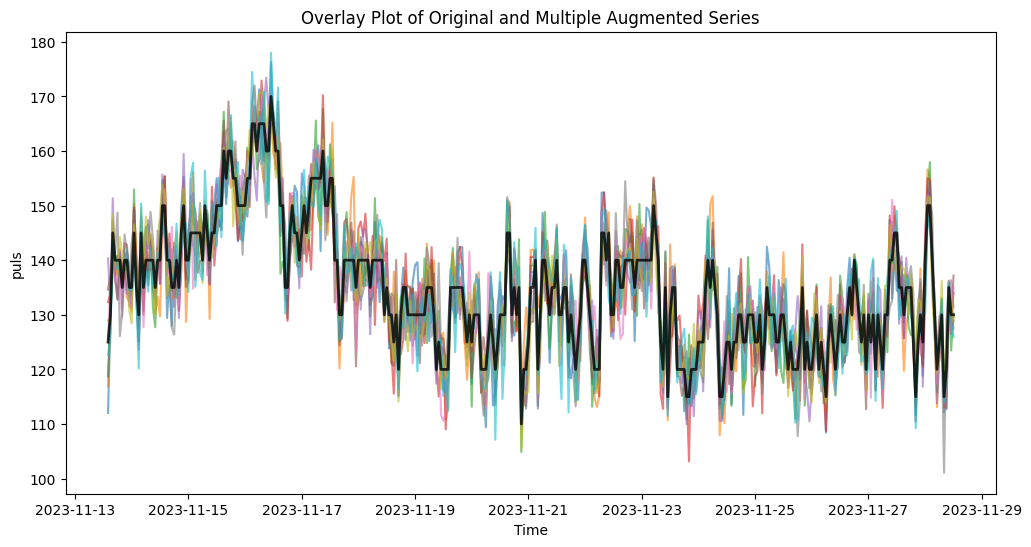

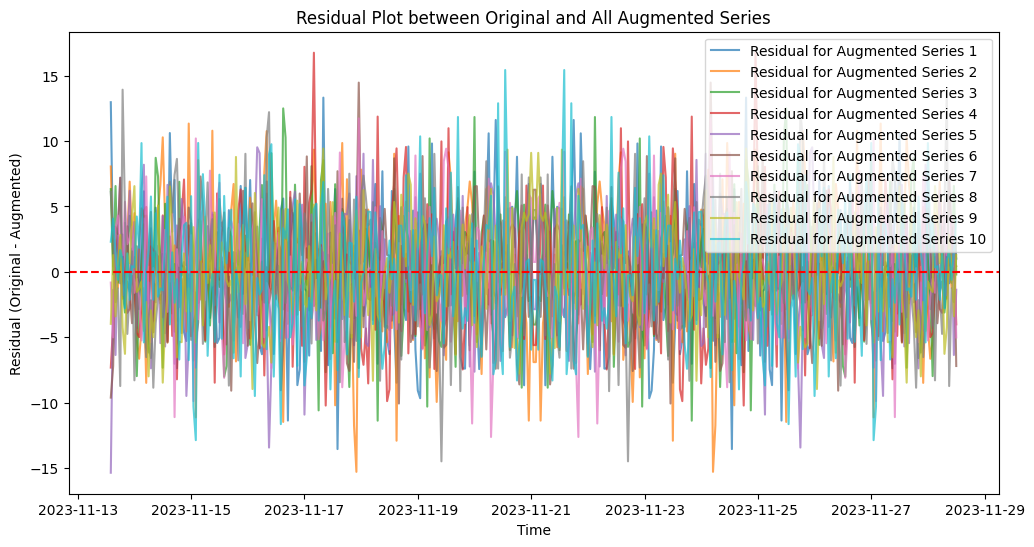

Original Mean: 134.8050139275766
Augmented Mean: 134.80501392757662
Original Variance: 127.26003057083666
Augmented Variance: 148.51604623219296


In [7]:
# statistical_comparison(original_series, augmented_series_list)
#plots
saving_path = 'images/08_FTT_aug/' + param + '_overlay_plot_' + str(num_of_augmented_series) + '_series.png'
plot_overlay_multiple(original_series, augmented_series_list, time, saving_path)
# frequency_spectrum_comparison_multiple(original_series, augmented_series_list)
# correlation_plot_multiple(original_series, augmented_series_list)
residual_plot_multiple(original_series, augmented_series_list, time)
# relative_residual_plot_multiple(original_series, augmented_series_list, time)

print("Original Mean:", np.mean(original_series))
print("Augmented Mean:", np.mean(augmented_series_list))
print("Original Variance:", np.var(original_series))
print("Augmented Variance:", np.var(augmented_series_list))

In [8]:
# for i in range(len(augmented_series_list)):
#     df_augmented[f"aug_series_{i:03d}"] = augmented_series_list[i]
df_list = [pd.DataFrame({f"aug_series_{i + 1:05d}": augmented_series_list[i]}) for i in range(len(augmented_series_list))]
df_augmented = pd.concat(df_list, axis=1)
df_augmented = df_augmented.map(round)
df_augmented.set_index(time, inplace = True)

In [9]:
df_augmented.head()

,aug_series_00001,aug_series_00002,aug_series_00003,aug_series_00004,aug_series_00005,aug_series_00006,aug_series_00007,aug_series_00008,aug_series_00009,aug_series_00010
date,,,,,,,,,,
2023-11-13 14:00:00,112,117,119,132,140,135,126,119,129,123
2023-11-13 15:00:00,129,130,130,134,131,137,135,127,129,126
2023-11-13 16:00:00,143,145,138,144,151,142,142,147,148,144
2023-11-13 17:00:00,139,141,141,137,137,137,136,141,139,141
2023-11-13 18:00:00,141,139,137,140,133,133,138,149,137,138


In [10]:
df_augmented.to_csv('data/df_augmented_'+ param + '.csv', index=True)

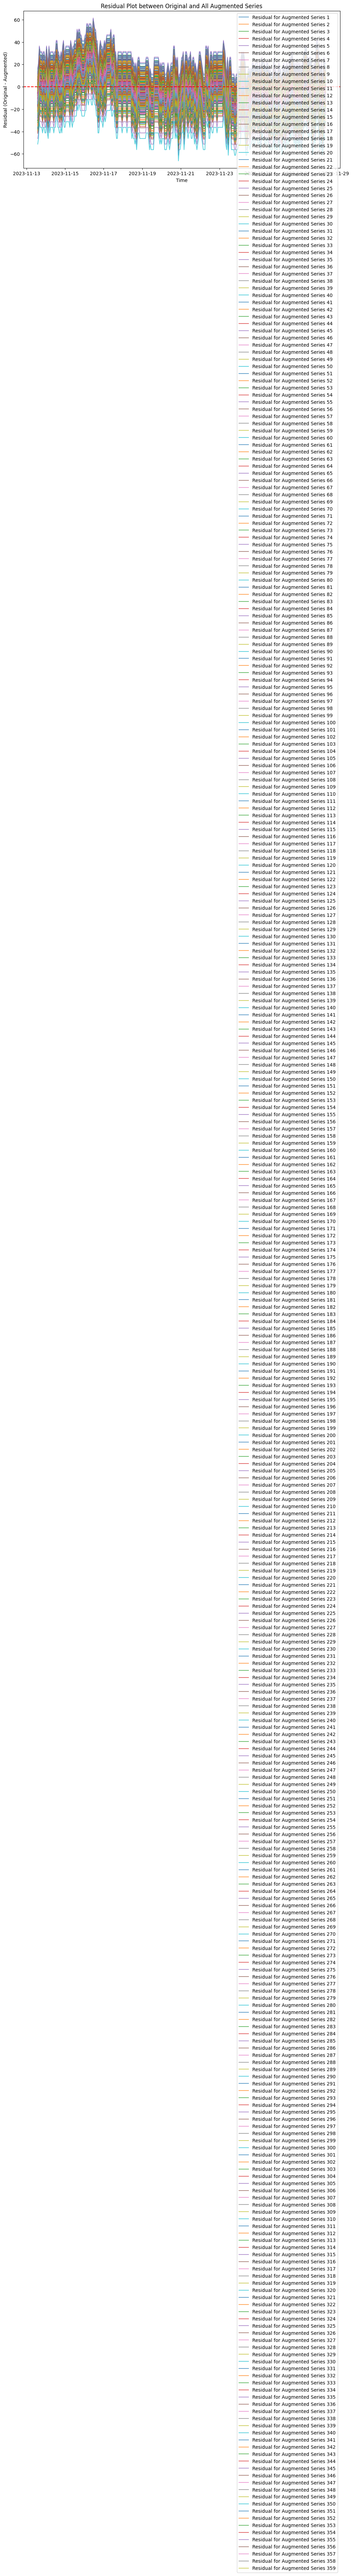